In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vanshkanjani","key":"a9ab53a2d612a23e7eedb7d16640a246"}'}

In [3]:
!kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!ls

kaggle.json  sample_data


In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
! echo '{"username":"vanshkanjani","key":"a9ab53a2d612a23e7eedb7d16640a246"}' > /root/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d gti-upm/leapgestrecog

100% 2.13G/2.13G [01:38<00:00, 26.7MB/s]
100% 2.13G/2.13G [01:38<00:00, 23.1MB/s]


In [9]:
! unzip "leapgestrecog" -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: ./leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: ./leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: ./leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: ./leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: ./leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: ./leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: ./leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: ./leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: ./leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: ./leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: ./leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: 

In [10]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
#preprocess.
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [11]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'09_c': 0,
 '05_thumb': 1,
 '07_ok': 2,
 '01_palm': 3,
 '02_l': 4,
 '08_palm_moved': 5,
 '06_index': 6,
 '04_fist_moved': 7,
 '03_fist': 8,
 '10_down': 9}

In [12]:
X_data = []
y_data = []
IMG_SIZE = 150
datacount = 0  # We'll use this to tally how many images are in our dataset

for i in range(0, 10):  # Loop over the ten top-level folders
    for j in os.listdir('leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'):  # Avoid hidden folders
            count = 0  # To tally images of a given gesture
            for k in os.listdir('leapgestrecog/leapGestRecog/0' +
                                str(i) + '/' + j + '/'):
                # Loop over the images
                path = 'leapgestrecog/leapGestRecog/0' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                arr = np.array(img)
                X_data.append(arr)
                count = count + 1
            y_values = np.full((count, 1), lookup[j])
            y_data.append(y_values)
            datacount = datacount + count

# Convert X_data to a numpy array after the loop
X_data = np.array(X_data, dtype='float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1)  # Reshape to be the correct size


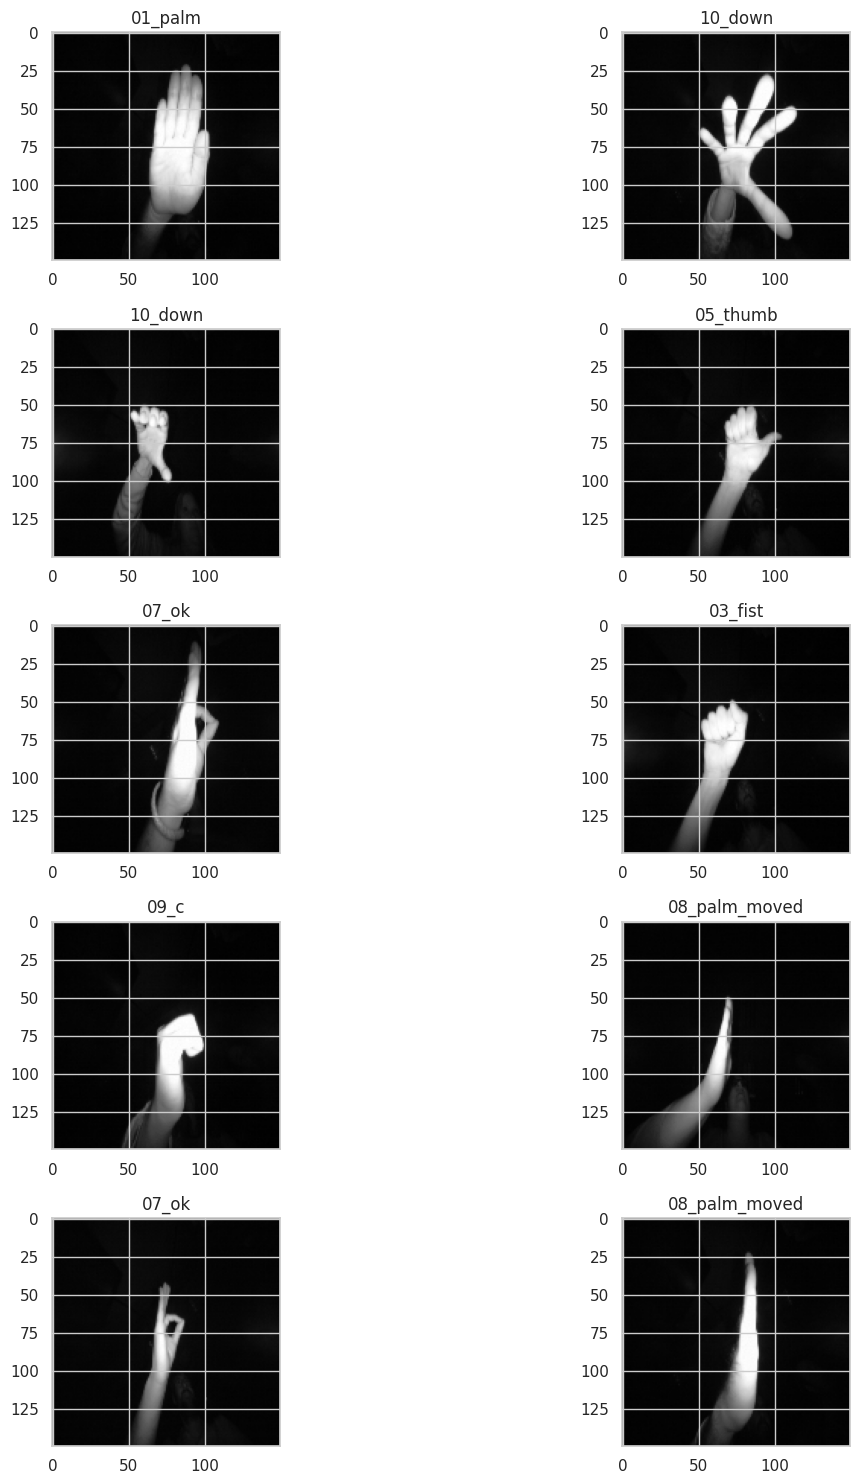

In [13]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 15)
for i in range(5):
    for j in range(2):
        l = rn.randint(0, len(y_data))
        ax[i, j].imshow(X_data[l], cmap='gray')  # Ensure to add the cmap argument for grayscale images
        ax[i, j].set_title(reverselookup[y_data[l, 0]])

plt.tight_layout()

In [14]:
y_data=to_categorical(y_data)
X_data = X_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
X_data = X_data/255

In [15]:
x_train,x_test,y_train,y_test=train_test_split(X_data,y_data,test_size=0.25,random_state=42)

In [16]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10, activation = "softmax"))

In [17]:
batchSize=128
epochs=10

In [18]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    save_freq='epoch'
)

tensorboard = TensorBoard(
    log_dir='./logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    mode='auto'
)

callbacks = [checkpoint, tensorboard, reduce]


In [19]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 96)        0

In [21]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batchSize, verbose=1, validation_data=(x_test, y_test), callbacks=callbacks)


Epoch 1/10
118/118 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.8821
Epoch 1: val_loss improved from inf to 0.03477, saving model to ./base.model
118/118 [==============================] - 27s 116ms/step - loss: 0.3505 - accuracy: 0.8821 - val_loss: 0.0348 - val_accuracy: 0.9922 - lr: 0.0010
Epoch 2/10
117/118 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9976
Epoch 2: val_loss improved from 0.03477 to 0.00520, saving model to ./base.model
118/118 [==============================] - 12s 98ms/step - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.0052 - val_accuracy: 0.9990 - lr: 0.0010
Epoch 3/10
117/118 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9990
Epoch 3: val_loss improved from 0.00520 to 0.00261, saving model to ./base.model
118/118 [==============================] - 12s 99ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0026 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 4/10
117/118 [==============

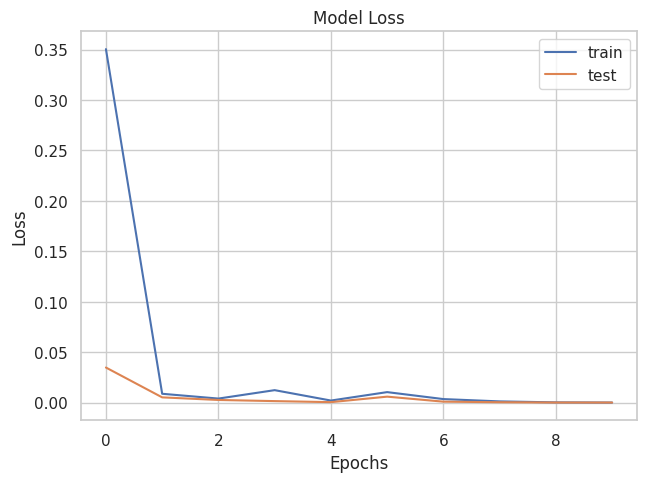

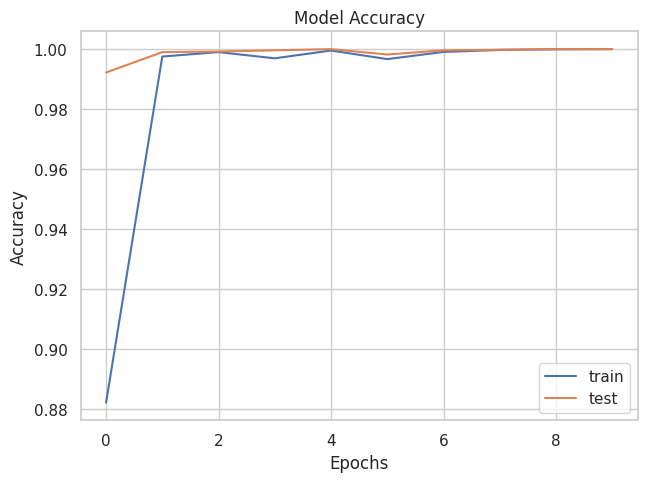

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 96)        0